In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA

df = pd.read_csv('A3/train.csv', index_col='ArticleId')
X_train = df['Text']
df['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_train = df['Category']

df_test = pd.read_csv('A3/test.csv', index_col='ArticleId')
X_test = df_test['Text']
df_test['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_test = df_test['Category']

temp_complete_test = pd.concat([X_train, X_test])

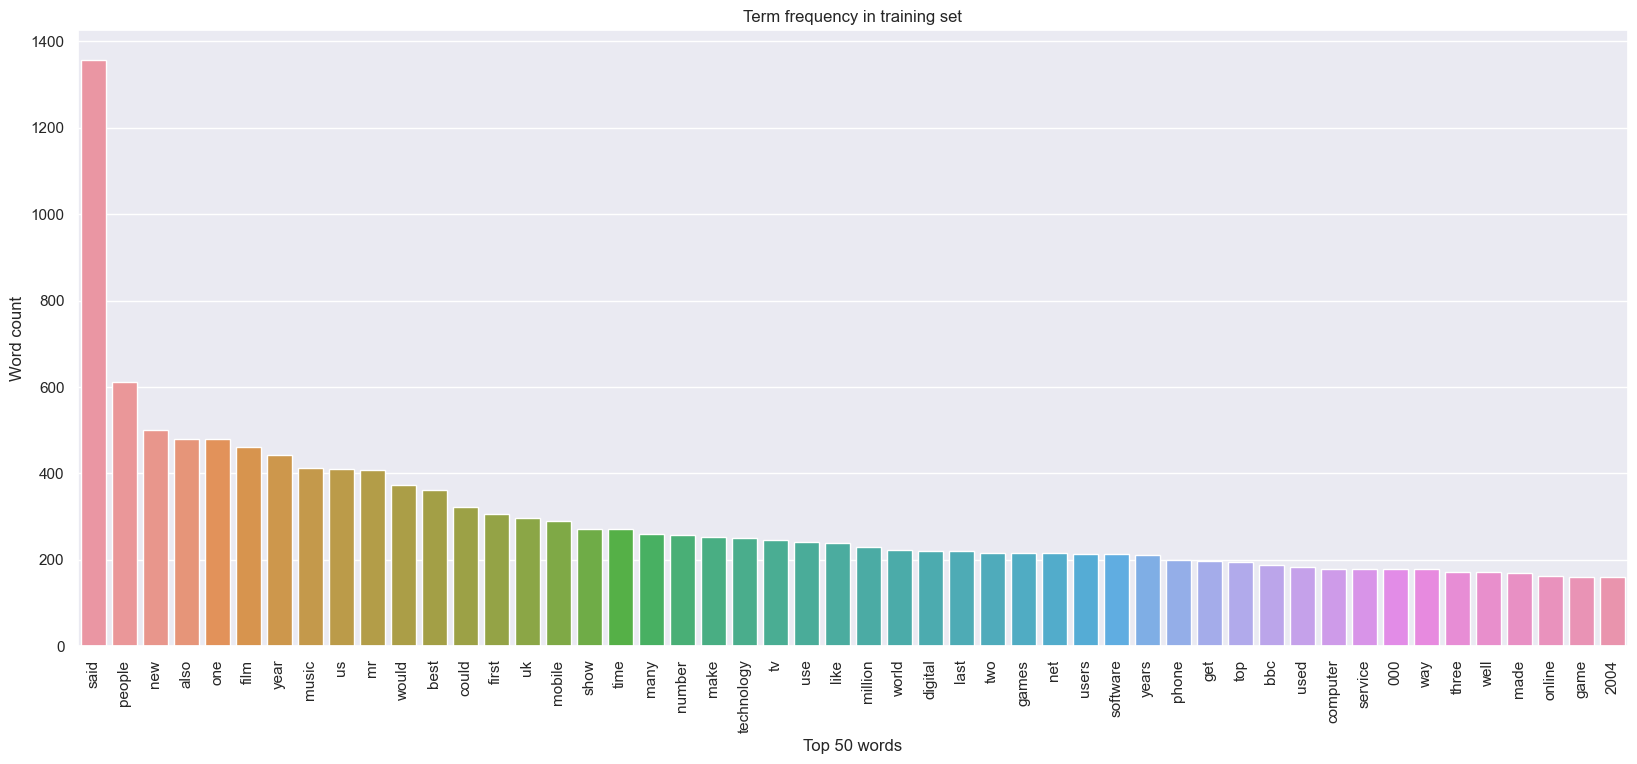

In [2]:
# Frequency count for dataset
vectorizer = CountVectorizer()
vectorizer.fit(temp_complete_test)
# Encode document
vector = vectorizer.transform(temp_complete_test)
prep_X_count = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=temp_complete_test.index)
#print(prep_X_count)

prep_X_train_count = prep_X_count[:428]
prep_X_test_count = prep_X_count[428:]

train_sum = prep_X_train_count.sum().sort_values(ascending=False)
test_sum = prep_X_test_count.sum().sort_values(ascending=False)

train_top_50 = train_sum.head(50)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(20,8)})
plot = sns.barplot(x=train_top_50.index, y=train_top_50.values)
plot.set_xlabel('Top 50 words')
plot.set_ylabel('Word count')
plot.set_title('Term frequency in training set')
plt.xticks(rotation = 90)
plt.show()

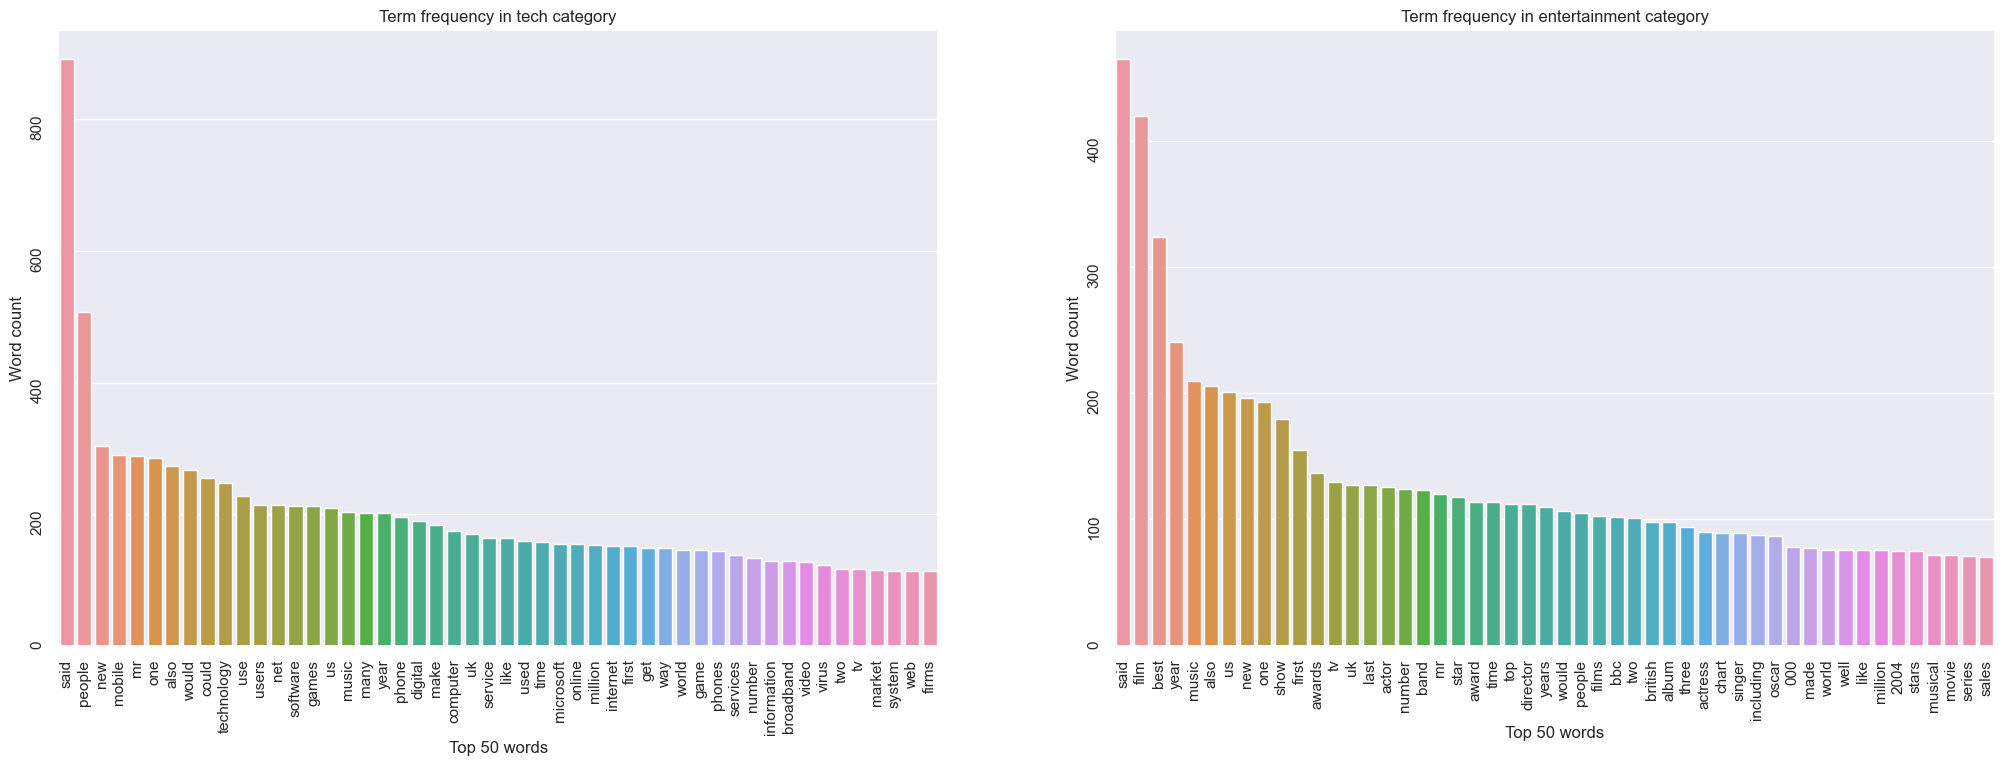

In [3]:
train_label_group = Y_train.groupby(Y_train)
train_tech, train_entertain = train_label_group.get_group(0).index, train_label_group.get_group(1).index

train_tech_sum = prep_X_count.loc[train_tech].sum().sort_values(ascending=False)
train_entertain_sum = prep_X_count.loc[train_entertain].sum().sort_values(ascending=False)

train_top_50_tech = train_tech_sum.head(50)
train_top_50_entertain = train_entertain_sum.head(50)

fig, ax = plt.subplots(ncols=2, figsize=(25, 8))
ax[0] = sns.barplot(x=train_top_50_tech.index, y=train_top_50_tech.values, ax=ax[0])
ax[0].set_xlabel('Top 50 words')
ax[0].set_ylabel('Word count')
ax[0].set_title('Term frequency in tech category')
ax[0].tick_params(labelrotation=90)

ax[1] = sns.barplot(x=train_top_50_entertain.index, y=train_top_50_entertain.values, ax=ax[1])
ax[1].set_xlabel('Top 50 words')
ax[1].set_ylabel('Word count')
ax[1].set_title('Term frequency in entertainment category')
ax[1].tick_params(labelrotation=90)
plt.show()

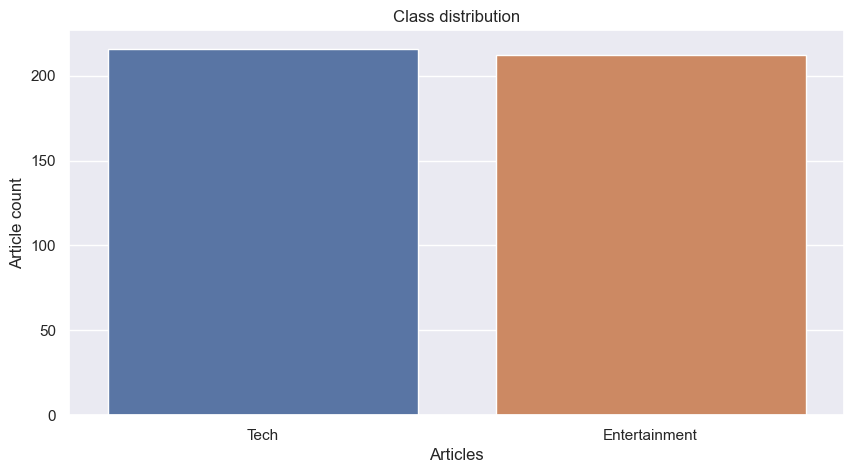

In [4]:
sns.set(rc = {'figure.figsize':(10,5)})
plot = sns.barplot(x=['Tech', 'Entertainment'], y=[train_tech.size, train_entertain.size])
plot.set_xlabel('Articles')
plot.set_ylabel('Article count')
plot.set_title('Class distribution')
plt.show()

In [5]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

# encode document
vector = vectorizer.transform(X_test)
prep_X_test = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_test.index)

vector = vectorizer.transform(X_train)
prep_X_train = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_train.index)
print(prep_X_test.shape)
print(prep_X_train.shape)

(106, 13518)
(428, 13518)


# Neural Network

## Task 2

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
import warnings

weight_init_range = [0,0.1]

# New MLP class to override init method to initialize weights
class MLPClassifierOverride(MLPClassifier):
    # Overriding _init_coef method
    def _init_coef(self, fan_in, fan_out, dtype):
        # Initialize weights and biases by uniformly sampling from range [0, 0.1]
        coef_init = np.random.uniform(
            weight_init_range[0], weight_init_range[1], (fan_in, fan_out)
        )
        intercept_init = np.random.uniform(weight_init_range[0], weight_init_range[1], fan_out)
        coef_init = coef_init.astype(dtype, copy=False)
        intercept_init = intercept_init.astype(dtype, copy=False)
        return coef_init, intercept_init

In [7]:
warnings.filterwarnings('ignore')

np.random.seed(11)

hid_units = [5,20,40]
results = []
training_losses = []

# Runs MLP model at every hidden unit and records loss
for hid_unit in hid_units:
    clf = MLPClassifierOverride(hidden_layer_sizes=(hid_unit,), solver='sgd', learning_rate_init=0.01, max_iter=100)
    clf.fit(prep_X_train,Y_train)

    preds = clf.predict(prep_X_test)
    
    score = f1_score(Y_test, preds)

    training_losses.append(clf.loss_curve_)
    results.append([hid_unit, score])

training_losses = np.array(training_losses)
print(results)

[[5, 0.5111111111111111], [20, 0.6021505376344086], [40, 0.7735849056603773]]


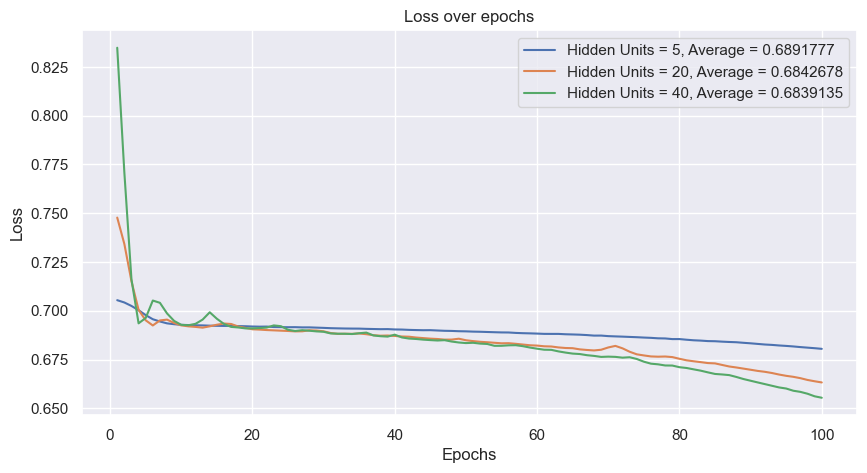

In [8]:
# Plots loss per epoch
epochs = np.arange(1, 101)
average_losses = np.mean(training_losses, axis=1)
average_losses = np.round(average_losses, decimals= 7)

plot = sns.lineplot(x = epochs, y = training_losses[0], label = str('Hidden Units = 5, Average = ' + str(average_losses[0])))
sns.lineplot(x = epochs, y = training_losses[1], label = str('Hidden Units = 20, Average = ' + str(average_losses[1])))
sns.lineplot(x = epochs, y = training_losses[2], label = str('Hidden Units = 40, Average = ' + str(average_losses[2])))
plot.set_title('Loss over epochs')
plot.set_xlabel('Epochs')
plot.set_ylabel('Loss')
plt.legend()
plt.show()

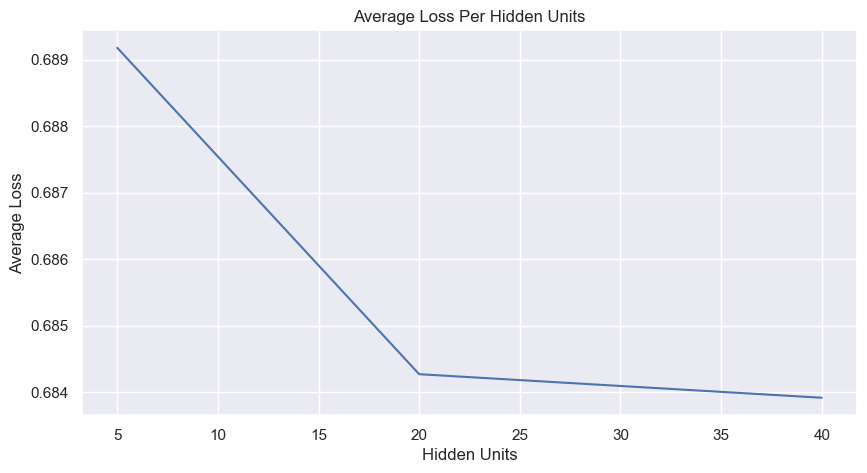

In [9]:
# Plots average loss per hidden units

plot = sns.lineplot(x = hid_units, y = average_losses)
plot.set_title('Average Loss Per Hidden Units')
plot.set_xlabel('Hidden Units')
plot.set_ylabel('Average Loss')
plt.show()

Given that we're isolating the effects of hidden units on the average loss in training, the graph shows that there's an inverse relationship between them. As hidden units increase, the average loss decreases. The graph above also shows the changes in loss over each epoch of training, and how there's more improvement in loss as we increase hidden units.

## Task 3

In [10]:
splits = [0.1, 0.3, 0.5, 0.7, 0.9]

np.random.seed(1)

T3_train_scores = []
T3_test_scores = []
train_size = prep_X_train.shape[0]

# Splits training set and runs a classifier per each one
for i in splits:
    split = int(i*train_size)
    T3_X_train = prep_X_train.iloc[:split]
    T3_y_train = Y_train.iloc[:split]

    T3_clf = MLPClassifier(activation='relu', alpha=0.1, learning_rate_init=0.01, hidden_layer_sizes=(20,20), solver='sgd')
    T3_clf.fit(T3_X_train, T3_y_train)

    train_pred = T3_clf.predict(T3_X_train)
    train_score = f1_score(T3_y_train, train_pred)

    test_pred = T3_clf.predict(prep_X_test)
    test_score = f1_score(Y_test, test_pred)

    T3_train_scores.append(train_score)
    T3_test_scores.append(test_score)
    
print(T3_test_scores)
print(T3_train_scores)

[0.673913043478261, 0.9838709677419354, 0.991869918699187, 0.9917355371900827, 0.9917355371900827]
[1.0, 0.9924812030075187, 1.0, 0.9965156794425087, 0.9974025974025974]


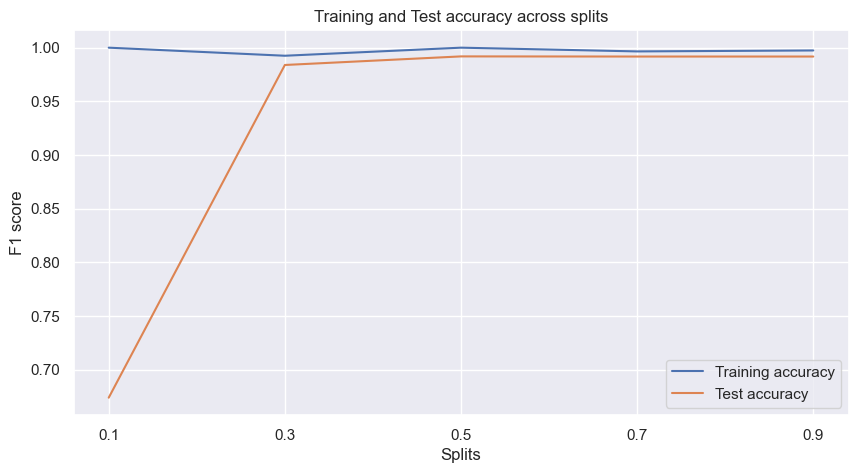

In [11]:
# Plots training and test accuracy splits
plot = sns.lineplot(x=[str(i) for i in splits], y=T3_train_scores, label = 'Training accuracy')
sns.lineplot(x=[str(i) for i in splits], y=T3_test_scores, label ='Test accuracy')
plot.set_title('Training and Test accuracy across splits')
plot.set(xlabel='Splits', ylabel='F1 score')

plt.show()

For Neural networks, training set size seems to be directly correlated to the f1-score. This makes sense as more training examples give the model better chances at converging to an optimal minima.

In [12]:
# Hyper parameters to tune:
# Shape of hidden layers (), Learning rate, weight initialization, l2 regularization alpha, activation
from sklearn.model_selection import GridSearchCV

shape_of_hidden_layers = [(20,), (40,), (10,10,), (20,20,), (40, 40,), (10,10,10,)]
learning_rate = [1,0.1,0.01,0.001,0.0001]
alpha = [1,0.1,0.01,0.001,0.0001]
activation = ['relu','logistic','tanh']

In [13]:
np.random.seed(5)

hid_clf = MLPClassifier(solver='sgd', random_state=5, batch_size=100)
hid_cv = GridSearchCV(hid_clf, {'hidden_layer_sizes': shape_of_hidden_layers}, scoring='f1', verbose=10, n_jobs=-1, return_train_score=True)
hid_cv.fit(prep_X_train,Y_train)

ler_clf = MLPClassifier(solver='sgd', random_state=5, batch_size=100)
ler_cv = GridSearchCV(ler_clf, {'learning_rate_init': learning_rate}, scoring='f1', verbose=10, n_jobs=-1, return_train_score=True)
ler_cv.fit(prep_X_train,Y_train)

alpha_clf = MLPClassifier(solver='sgd', random_state=5, batch_size=100)
alpha_cv = GridSearchCV(alpha_clf, {'alpha': alpha}, scoring='f1', verbose=10, n_jobs=-1, return_train_score=True)
alpha_cv.fit(prep_X_train,Y_train)

activation_clf = MLPClassifier(solver='sgd', random_state=5, batch_size=100)
activation_cv = GridSearchCV(activation_clf, {'activation': activation}, scoring='f1', verbose=10, n_jobs=-1, return_train_score=True)
activation_cv.fit(prep_X_train,Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(estimator=MLPClassifier(batch_size=100, random_state=5,
                                     solver='sgd'),
             n_jobs=-1, param_grid={'activation': ['relu', 'logistic', 'tanh']},
             return_train_score=True, scoring='f1', verbose=10)

In [14]:
# Retrieves best options of hyperparameters per cross validation step

best_hid = hid_cv.best_params_['hidden_layer_sizes']
best_ler = ler_cv.best_params_['learning_rate_init']
best_alpha = alpha_cv.best_params_['alpha']
best_activation = activation_cv.best_params_['activation']

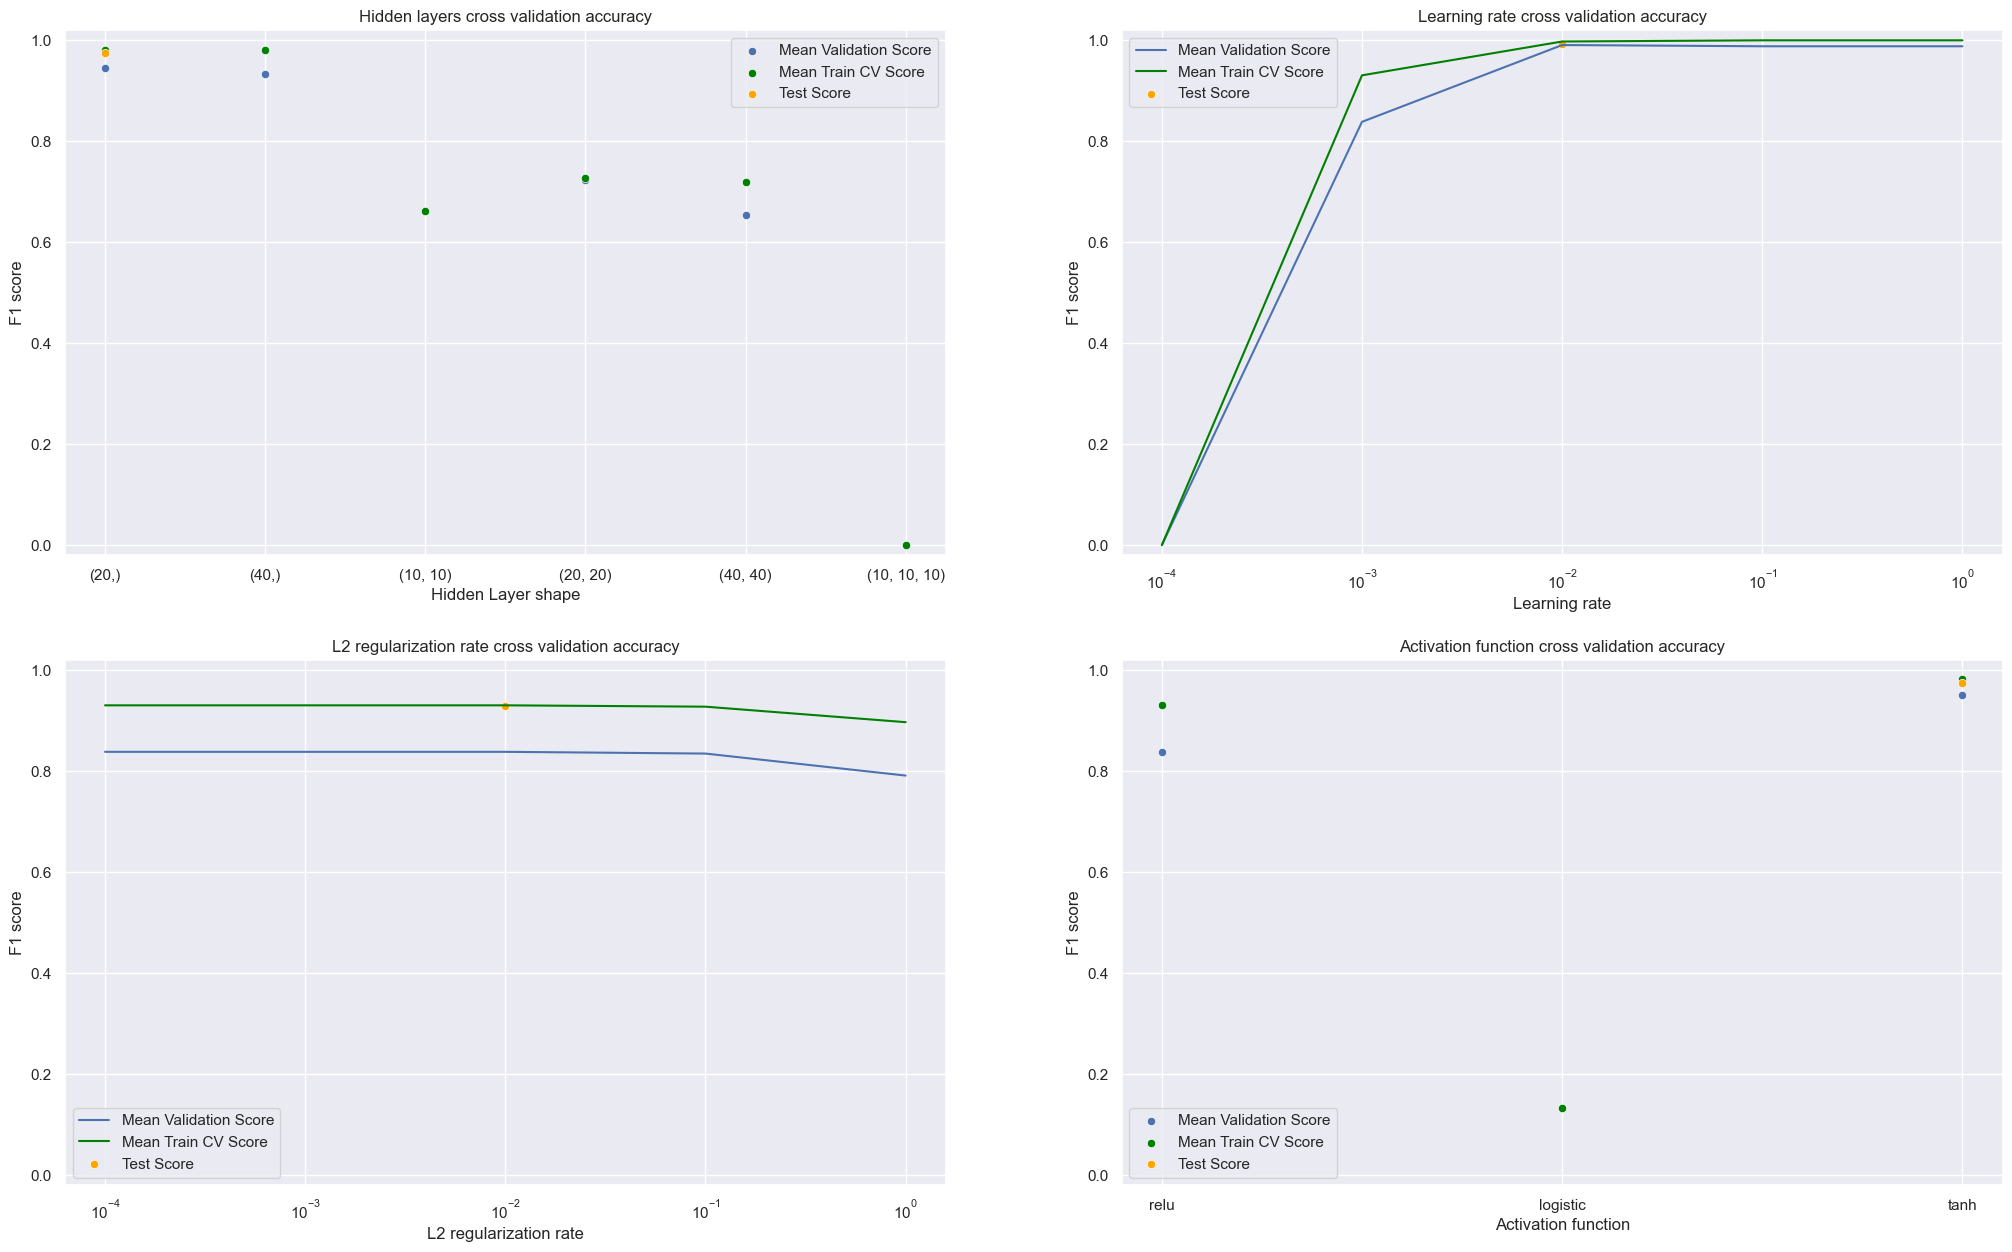

Training set f1-score = 0.9814. Validation set f1-score = 0.9458. Test set f1-score = 0.9752. Hidden layer shape = (20,)
Training set f1-score = 1.0000. Validation set f1-score = 0.9906. Test set f1-score = 0.9917. Learning rate = 0.01
Training set f1-score = 0.9307. Validation set f1-score = 0.8385. Test set f1-score = 0.9298. L2 regularization rate = 0.01
Training set f1-score = 0.9833. Validation set f1-score = 0.9512. Test set f1-score = 0.9748. Activation function = tanh


In [24]:
string_hlayers = [str(i) for i in shape_of_hidden_layers]
hid_score = hid_cv.score(prep_X_test, Y_test)
ler_score = ler_cv.score(prep_X_test, Y_test)
alpha_score = alpha_cv.score(prep_X_test, Y_test)
activation_score = activation_cv.score(prep_X_test, Y_test)

# Plots the training and validation mean scores as well as the test result for tuned hyperparameter
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(25, 15))
ax[0, 0] = sns.scatterplot(x=string_hlayers, y=hid_cv.cv_results_['mean_test_score'], ax=ax[0,0], label='Mean Validation Score')
ax[0, 0].set_title('Hidden layers cross validation accuracy')
ax[0, 0].set(xlabel='Hidden Layer shape', ylabel='F1 score')
ax[0, 0].set_ylim(-.02,1.02)
sns.scatterplot(x=string_hlayers, y=hid_cv.cv_results_['mean_train_score'], ax=ax[0, 0], color = 'green', label='Mean Train CV Score')
sns.scatterplot(x=[str(best_hid)], y=hid_score, ax=ax[0, 0], color = 'orange', label='Test Score')

ax[0, 1] = sns.lineplot(x=learning_rate, y=ler_cv.cv_results_['mean_test_score'], ax=ax[0,1], label='Mean Validation Score')
ax[0, 1].set(xscale="log")
ax[0, 1].set_title('Learning rate cross validation accuracy')
ax[0, 1].set(xlabel='Learning rate', ylabel='F1 score')
ax[0, 1].set_ylim(-.02,1.02)
sns.lineplot(x=learning_rate, y=ler_cv.cv_results_['mean_train_score'], ax=ax[0, 1], color = 'green', label='Mean Train CV Score')
sns.scatterplot(x=[float(best_ler)], y=ler_score, ax=ax[0, 1], color = 'orange', label='Test Score')

ax[1, 0] = sns.lineplot(x=alpha, y=alpha_cv.cv_results_['mean_test_score'], ax=ax[1, 0], label='Mean Validation Score')
ax[1, 0].set(xscale="log")
ax[1, 0].set_title('L2 regularization rate cross validation accuracy')
ax[1, 0].set(xlabel='L2 regularization rate', ylabel='F1 score')
ax[1, 0].set_ylim(-.02,1.02)
sns.lineplot(x=alpha, y=alpha_cv.cv_results_['mean_train_score'], ax=ax[1, 0], color = 'green', label='Mean Train CV Score')
sns.scatterplot(x=[float(best_alpha)], y=alpha_score, ax=ax[1, 0], color = 'orange', label='Test Score')

ax[1, 1] = sns.scatterplot(x=activation, y=activation_cv.cv_results_['mean_test_score'], ax=ax[1, 1], label='Mean Validation Score')
ax[1, 1].set_title('Activation function cross validation accuracy')
ax[1, 1].set(xlabel='Activation function', ylabel='F1 score')
ax[1, 1].set_ylim(-.02,1.02)
sns.scatterplot(x=activation, y=activation_cv.cv_results_['mean_train_score'], ax=ax[1, 1], color = 'green', label='Mean Train CV Score')
sns.scatterplot(x=[best_activation], y=activation_score, ax=ax[1, 1], color = 'orange', label='Test Score')

plt.show()

print('Training set f1-score = %.4f. Validation set f1-score = %.4f. Test set f1-score = %.4f. Hidden layer shape = %s' \
      %(max(hid_cv.cv_results_['mean_train_score']), hid_cv.best_score_, hid_score, best_hid))
print('Training set f1-score = %.4f. Validation set f1-score = %.4f. Test set f1-score = %.4f. Learning rate = %s' \
      %(max(ler_cv.cv_results_['mean_train_score']), ler_cv.best_score_, ler_score, best_ler))
print('Training set f1-score = %.4f. Validation set f1-score = %.4f. Test set f1-score = %.4f. L2 regularization rate = %s' \
      %(max(alpha_cv.cv_results_['mean_train_score']), alpha_cv.best_score_, alpha_score, best_alpha))
print('Training set f1-score = %.4f. Validation set f1-score = %.4f. Test set f1-score = %.4f. Activation function = %s' \
      %(max(activation_cv.cv_results_['mean_train_score']), activation_cv.best_score_, activation_score, best_activation))

Using a 5 fold cross validation in our training dataset, we can see trends in the different hyperparameteres we used. Training a neural network requires time and powerful hardware, hence why we just focused on looking into the effects of individual hyperparameters per cross validation step rather than a combination of multiple hyperparameters. Each cross validation changes one hyperparameter, while keeping all others at default. This does have its caveats as default max epochs is 200. Performance might get affected as some hyperparameters like learning rate and hidden layers might prevent the model from converging at an optimal result before stopping. Batch gradient descent was also implemented with 100 exmaples per batch. This is to reduce computational cost, but at the possibility of lowering performance. The plot above shows the mean cv score per each hyper parameter training, as well as its training scores. This is to detect the bias-variance tradeoff during cross validation. Test scores are retrieved from refitting the model with the best hyperparameter using the entire training dataset. For this reason, we see some improvement from our cross validation scores to our test scores. 

- Weight initialization is a hyper parameter, and from the results of Task 2d, randomizing the weights isn't an ideal choice. Scikit implements the Xavier-Glorot initialization which is a widely used initialization technique that uniformly samples the weights of the current layer depending on both sizes of the current and its previous layer. This has shown better results in all our cross validations. 
- Increasing both the number of neurons and hidden layers adds complexity to our model. In the first graph, we can see that one hidden layer with sizes 20 and 40 is enough to outperform the other more complex options. This might be because our data is separable enough that it doesn't need much complexity to effectively classify it. 
- Learning rate determines the steps the model takes during SGD. Scikit limits the max epochs to 200 and thus smaller learning rates might not even converge at all. There's also a possibility that it might get stuck in a local minima, thus decreasing performance. Larger weights on the other hand might completely miss the minima and underfit the model. In our case, a higher choice of learning rate gives better bias with little variance as well.
- We've tried exploring the effects of L2 regularization in our model and found that a regularization rate of 0.01 seems to provide us with the best results. Lower L2 regularization rates typically result in more complex representations in the data. This might result in lower bias but higher variance, which we can notice from the gap in the graph.
- Lastly for the activation function, we found that a tanh activation function proved to be helpful in our classification. The default scikit NN only has a single layer with 100 neurons that connects to the output, and thus is not prone to any vanishing or exploding gradients. A tanh activation function adds more non-linearity to our model compared to ReLU. This choice seems to also perform better in our model than sigmoid.

0.9917355371900827


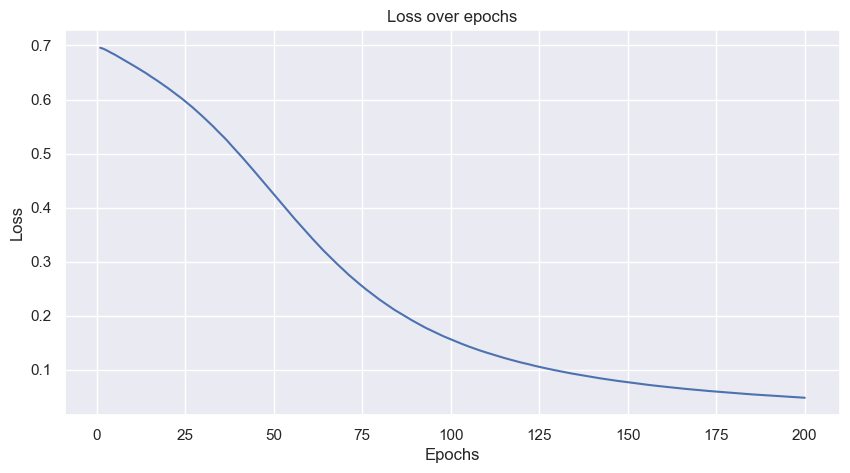

In [16]:
# Using final hyperparameters used in tuning
np.random.seed(5)

final_clf = MLPClassifier(activation=best_activation, alpha=best_alpha, learning_rate_init=best_ler, hidden_layer_sizes=best_hid, solver='sgd', batch_size=100)
final_clf.fit(prep_X_train,Y_train)
loss_list = np.array(final_clf.loss_curve_)

pred = final_clf.predict(prep_X_test)
score = f1_score(Y_test, pred)
print(score)

epochs = np.arange(1, len(loss_list)+1)

plot = sns.lineplot(x = epochs, y = loss_list)
plot.set_title('Loss over epochs')
plot.set_xlabel('Epochs')
plot.set_ylabel('Loss')
plt.show()